# Mapping extreme heat in NWS forecast zones

#### Import Python tools

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_stiles as altstiles
import numpy as np
from datetime import date
import requests
import json
import matplotlib.pyplot as plt
import jenkspy
import matplotlib.colors as colors
from cartopy import crs as ccrs
import glob
from PIL import Image
import us
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
alt.themes.register("stiles", altstiles.theme)
alt.themes.enable("stiles")

ThemeRegistry.enable('grid')

In [4]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [5]:
today = pd.to_datetime("today").strftime("%Y-%m-%d")

---

## Read data

#### Get the heat warning/watch counts by place and year (with population estimates)

In [6]:
df = pd.read_csv("data/processed/excessive_heat_warnings.csv")

In [7]:
df.head()

year state_zone  count  days        name state  pop_share
0  2008      AL001      1  0.02  Lauderdale    AL    94535.0
1  2008      AL002      1  0.02     Colbert    AL    56523.0
2  2008      AL003      1  0.02    Franklin    AL    31586.0
3  2008      AL004      1  0.02    Lawrence    AL    34680.0
4  2008      AL005      1  0.02   Limestone    AL    96933.0

In [8]:
len(df)

14341

In [9]:
df.head()

year state_zone  count  days        name state  pop_share
0  2008      AL001      1  0.02  Lauderdale    AL    94535.0
1  2008      AL002      1  0.02     Colbert    AL    56523.0
2  2008      AL003      1  0.02    Franklin    AL    31586.0
3  2008      AL004      1  0.02    Lawrence    AL    34680.0
4  2008      AL005      1  0.02   Limestone    AL    96933.0

#### Zones geography

In [10]:
zones = gpd.read_file("data/processed/public_forecast_zones.geojson")

In [11]:
len(zones)

3826

#### Merge them

In [12]:
gdf = gpd.GeoDataFrame(df.merge(zones, on=["state_zone", "state", "name"]))

In [13]:
len(gdf)

14758

In [14]:
gdf = gdf.dropna(subset=["count", "days"])

In [15]:
gdf.head()

year state_zone  count  days        name state  pop_share  \
0  2008      AL001      1  0.02  Lauderdale    AL    94535.0   
1  2010      AL001      3  5.88  Lauderdale    AL    94535.0   
2  2011      AL001      4  2.74  Lauderdale    AL    94535.0   
3  2012      AL001      3  3.24  Lauderdale    AL    94535.0   
4  2019      AL001      1  1.28  Lauderdale    AL    94535.0   

                                            geometry  
0  POLYGON ((-87.98530 35.00591, -88.20229 35.007...  
1  POLYGON ((-87.98530 35.00591, -88.20229 35.007...  
2  POLYGON ((-87.98530 35.00591, -88.20229 35.007...  
3  POLYGON ((-87.98530 35.00591, -88.20229 35.007...  
4  POLYGON ((-87.98530 35.00591, -88.20229 35.007...

In [16]:
breaks = jenkspy.jenks_breaks(list(gdf.days), n_classes=6)
breaks

[0.01, 2.83, 6.01, 11.52, 20.4, 37.92, 74.12]

In [17]:
breaks_manual = [1, 3, 5, 10, 20, 40, 74.12]
breaks_manual

[1, 3, 5, 10, 20, 40, 74.12]

#### States

In [18]:
states = gpd.read_file("/Users/stiles/data/gis/usa_states_esri_simple.json")

In [19]:
states = states[~states["STATE_NAME"].isin(["Alaska", "Hawaii"])]

#### Cities

In [20]:
cities = gpd.read_file("/Users/stiles/data/gis/USA_Major_Cities.geojson")[
    ["NAME", "ST", "CAPITAL", "POPULATION", "geometry"]
]

In [21]:
cities.columns = cities.columns.str.lower()

In [22]:
postal_to_ap = us.states.mapping("abbr", "ap_abbr")

In [23]:
cities["st"] = cities["st"].map(postal_to_ap)

In [24]:
big_cities = cities[cities["population"] > 1500000]

In [25]:
big_capital_cities = cities[
    (cities["capital"] == "State") & (cities["population"] > 400000)
]

In [26]:
our_city_list = [
    "Tulsa",
    "Spokane",
    "Yuma",
    "Bakersfield",
    "Los Angeles",
    # "San Francisco",
    "Sacramento",
    "Phoenix",
]
our_cities = cities[cities["name"].isin(our_city_list)]

In [27]:
albo = ccrs.AlbersEqualArea(
    central_longitude=-96,
    central_latitude=37.5,
    false_easting=0.0,
    false_northing=0.0,
    standard_parallels=(29.5, 45.5),
    globe=None,
)

In [28]:
gdf = gdf.to_crs(albo.proj4_init)
states = states.to_crs(albo.proj4_init)
zones = zones.to_crs(albo.proj4_init)
cities = cities.to_crs(albo.proj4_init)
big_cities = big_cities.to_crs(albo.proj4_init)
our_cities = our_cities.to_crs(albo.proj4_init)

In [29]:
years = gdf.year.sort_values().unique()

In [30]:
cmap = ListedColormap(
    ["#feedde", "#fdd0a2", "#fdae6b", "#fd8d3c", "#e6550d", "#a63603"]
)

In [31]:
breaks_manual

[1, 3, 5, 10, 20, 40, 74.12]

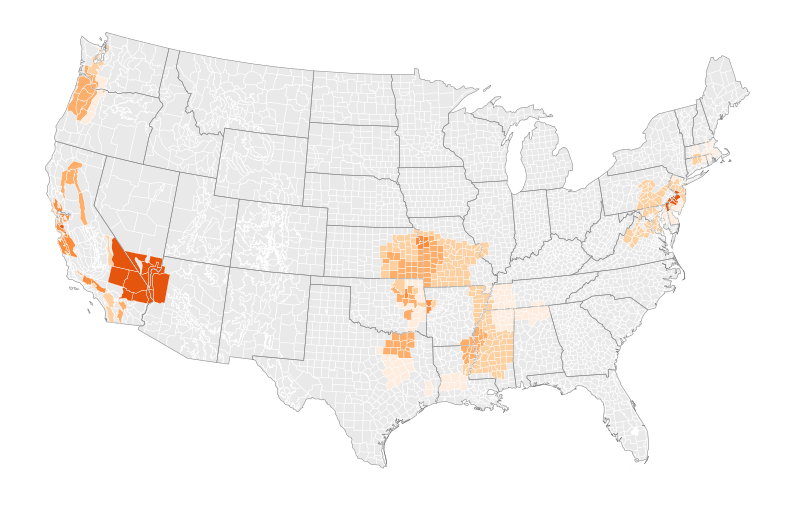

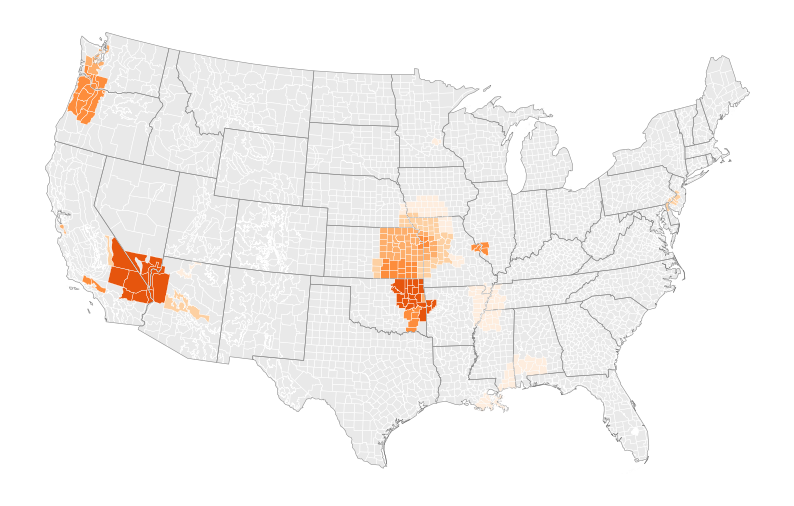

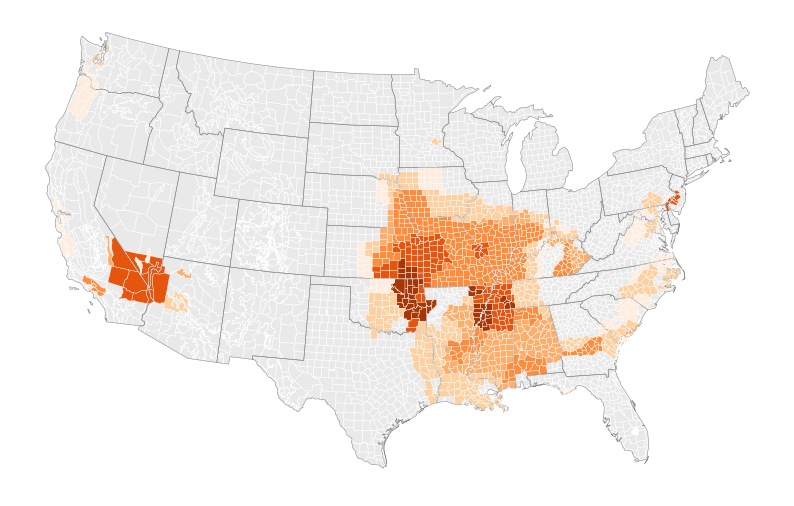

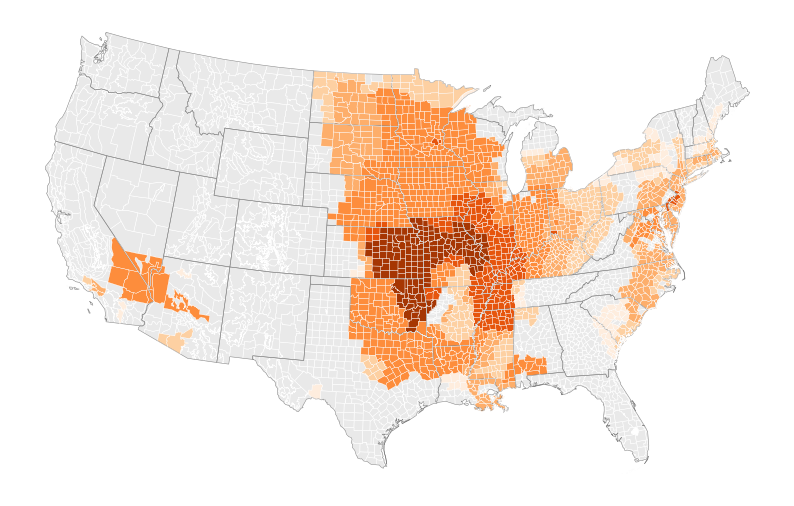

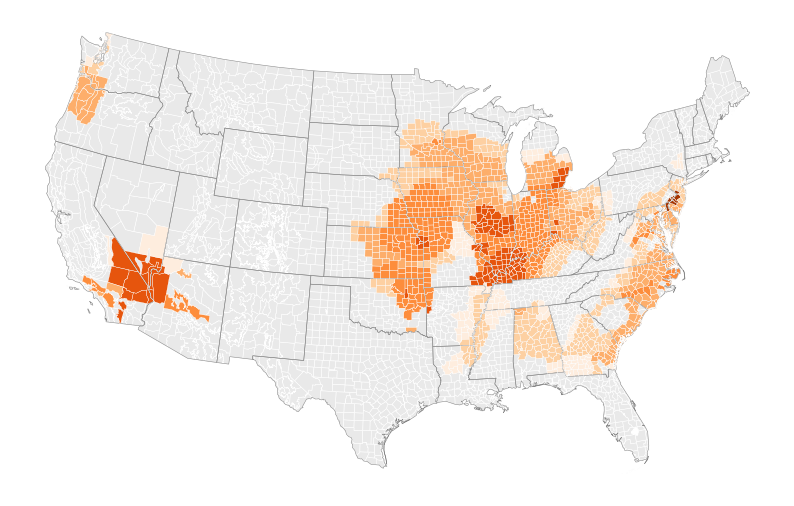

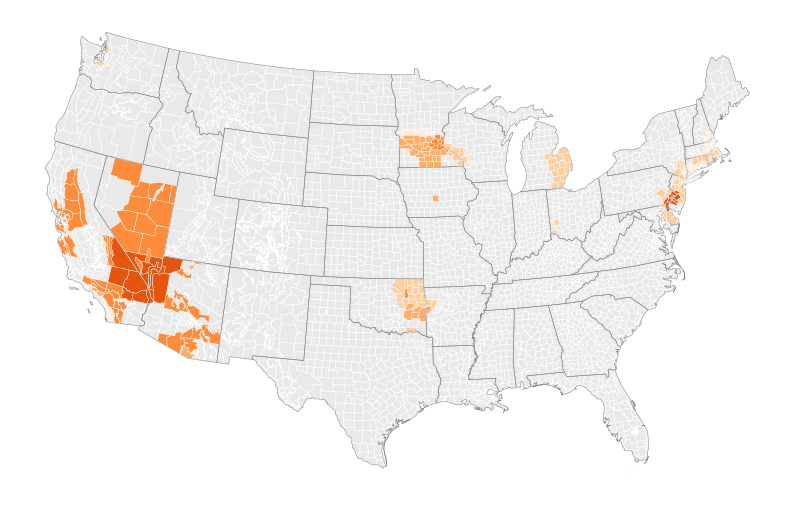

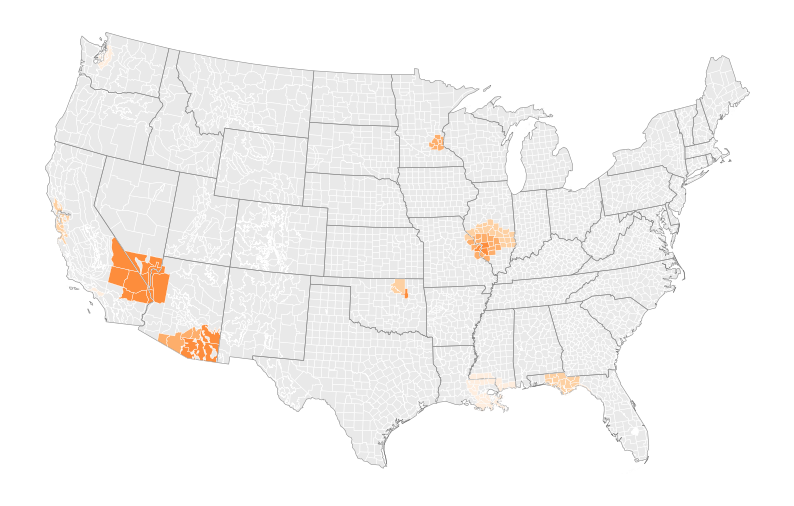

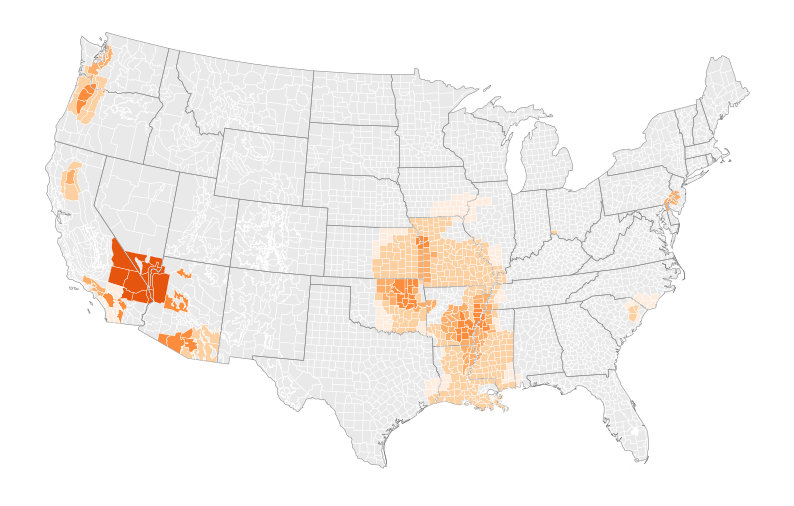

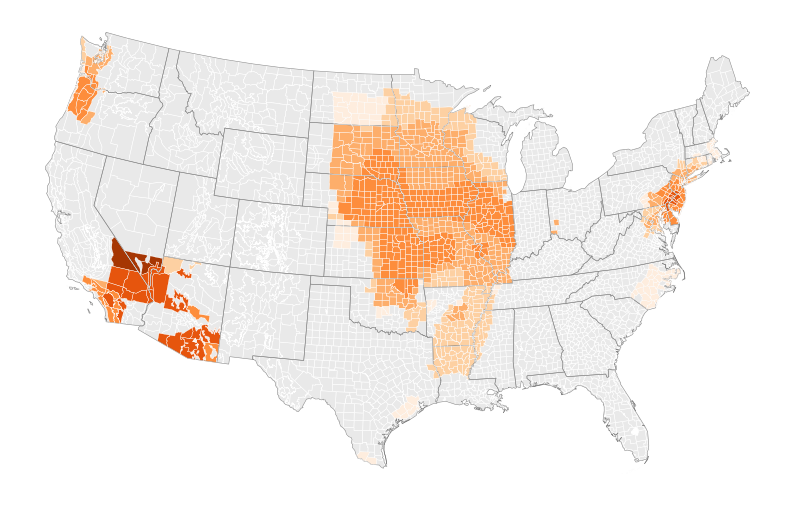

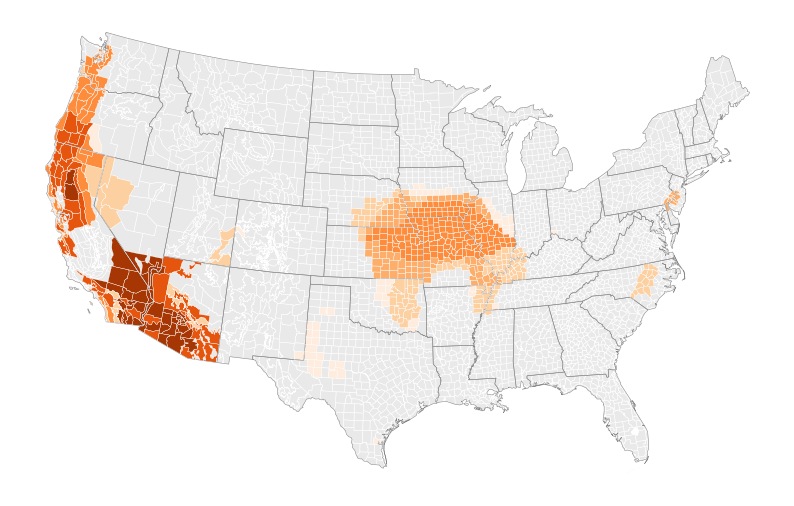

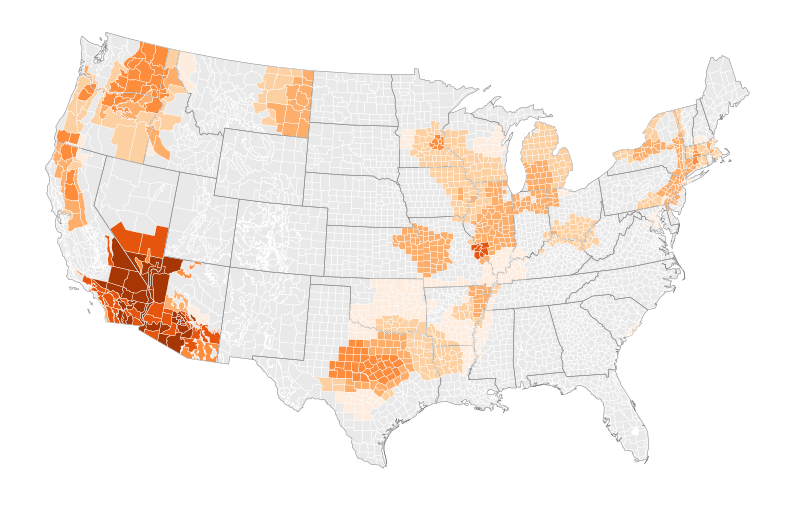

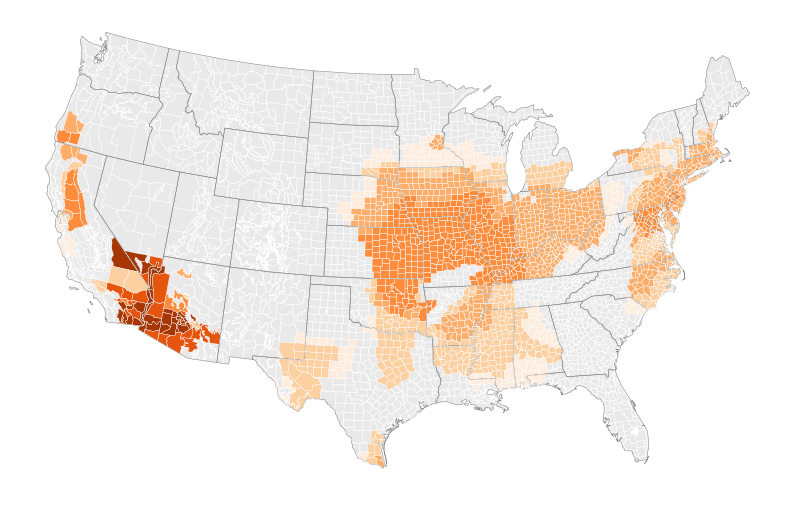

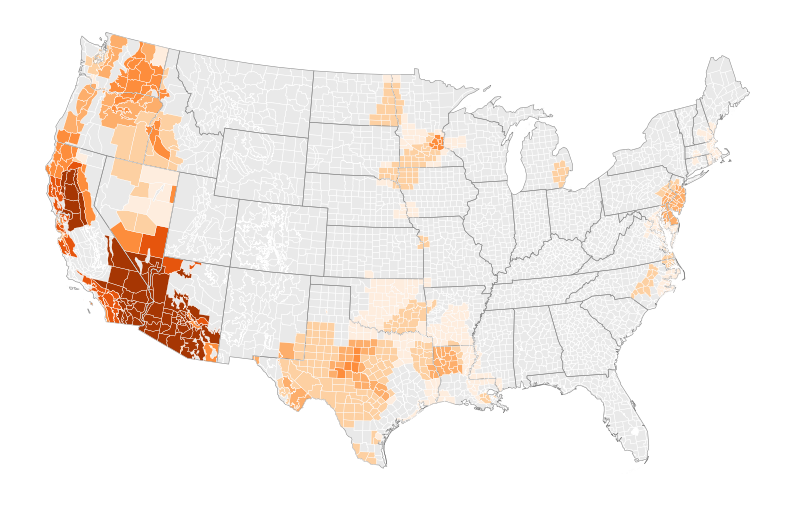

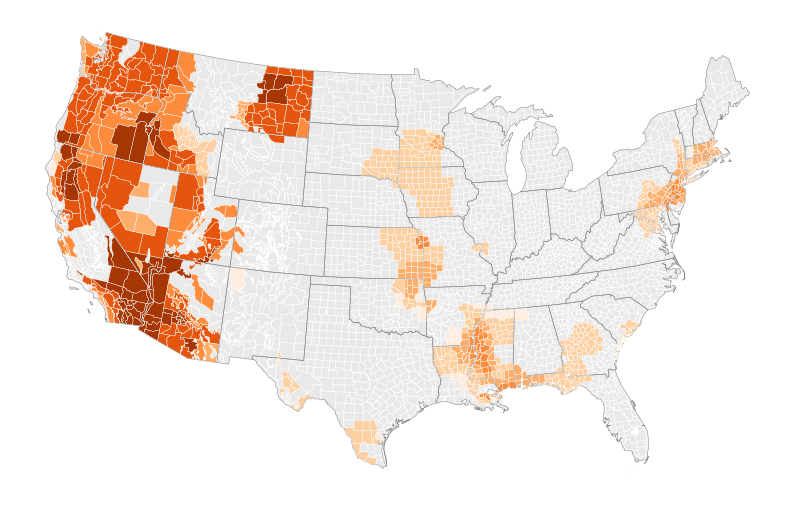

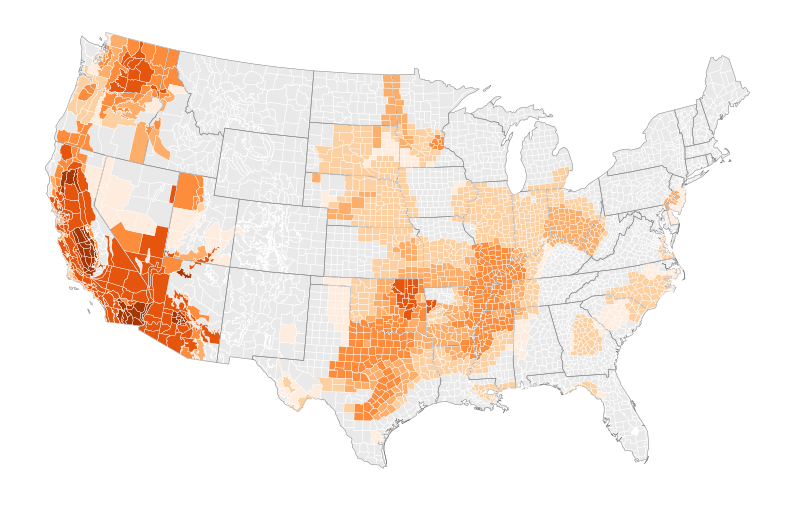

In [32]:
for y in years:

    ax = gdf[gdf["year"] == y].boundary.plot(
        edgecolor="white", linewidth=0.2, figsize=(10, 7)
    )

    zones.plot(ax=ax, facecolor="#e9e9e9", edgecolor="#fff", linewidth=0.4)

    gdf[gdf["year"] == y].plot(
        ax=ax,
        column="days",
        legend=False,
        categorical=True,
        cmap=cmap,
        scheme="User_Defined",
        classification_kwds=dict(bins=breaks_manual),
    )

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    for edge in ["right", "bottom", "top", "left"]:
        ax.spines[edge].set_visible(False)

    states.plot(ax=ax, facecolor="none", edgecolor="#888", linewidth=0.4)

    plt.savefig(
        f"../../graphics/extreme-heat-maps-20220823/images/map_{y}.png",
        dpi=72,
        transparent=True,
        pad_inches=0,
        bbox_inches="tight",
    )

In [33]:
gdf.head()

year state_zone  count  days        name state  pop_share  \
0  2008      AL001      1  0.02  Lauderdale    AL    94535.0   
1  2010      AL001      3  5.88  Lauderdale    AL    94535.0   
2  2011      AL001      4  2.74  Lauderdale    AL    94535.0   
3  2012      AL001      3  3.24  Lauderdale    AL    94535.0   
4  2019      AL001      1  1.28  Lauderdale    AL    94535.0   

                                            geometry  
0  POLYGON ((724552.712 -248752.916, 704963.850 -...  
1  POLYGON ((724552.712 -248752.916, 704963.850 -...  
2  POLYGON ((724552.712 -248752.916, 704963.850 -...  
3  POLYGON ((724552.712 -248752.916, 704963.850 -...  
4  POLYGON ((724552.712 -248752.916, 704963.850 -...

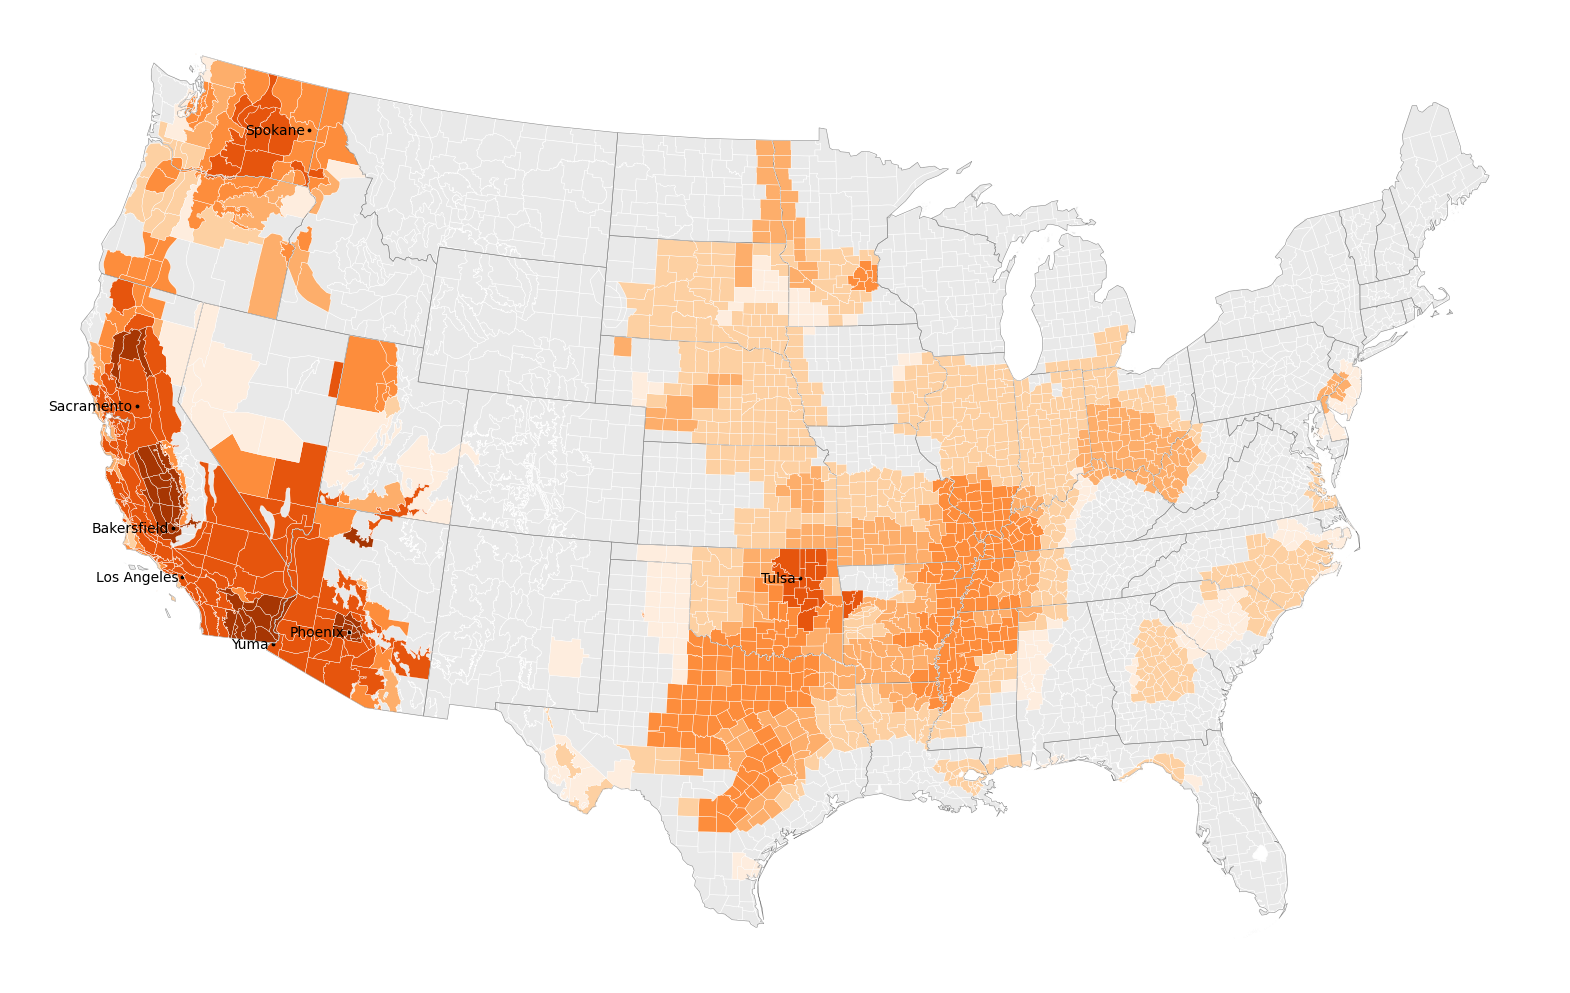

In [34]:
ax = gdf[gdf["year"] == 2022].boundary.plot(
    edgecolor="white", linewidth=0.2, figsize=(20, 14)
)

zones.plot(ax=ax, facecolor="#e9e9e9", edgecolor="#fff", linewidth=0.4)

gdf[gdf["year"] == 2022].plot(
    ax=ax,
    column="days",
    legend=False,
    categorical=True,
    cmap=cmap,
    scheme="User_Defined",
    classification_kwds=dict(bins=breaks_manual),
)

our_cities.plot(ax=ax, color="black", markersize=3)

for x, y, label in zip(our_cities.geometry.x, our_cities.geometry.y, our_cities.name):
    ax.annotate(
        label,
        xy=(x, y),
        xytext=(-3, -3),
        textcoords="offset points",
        # color="black",
        # size=16,
        # font="Summit Sans",
        ha="right",
    )

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

for edge in ["right", "bottom", "top", "left"]:
    ax.spines[edge].set_visible(False)

states.plot(ax=ax, facecolor="none", edgecolor="#888", linewidth=0.4)

plt.savefig(
    f"../../graphics/extreme-heat-days-map-20220823/assets/map_2022_large.svg",
    dpi=72,
    transparent=True,
    pad_inches=0,
    bbox_inches="tight",
)